Authors: Ahmadkhaniha and Bathaee - GPU used for batch = 30 is NVIDIA GeForce GTX 1080 Ti with the RAM 8 and the number of computational core 2560 - Tensorflow version is 2.12.0-Pennylane version is 0.30.0 - The m-1-m DQNN-based QAE  with the conjugate layer $V^2=V^{1\dagger}$ and modified decoder. The target state is noisy. m=2, p=0.2 and shot=$2^{15}$. The number of dataset is batch. Please change batch = 30 to see the result exactly as the same as in our paper PRA DOI: 10.1103/PhysRevA.00.002600, http://arxiv.org/abs/2311.10467.

In [1]:
import pennylane as qml
import tensorflow as tf
from pennylane import numpy as np

In [2]:
#m-1-m quantum neural network with a conjugate layer and modified decoder
m=2 #number of GHZ's qubits
npar = 3*2*m #number of learning parameters
h = 1
def dqnn(m,params,**kwargs):
    #V1
    j=0
    s=0
    for i in range(m):   
        qml.U3(params[j], params[j+1], params[j+2], wires=2*m+h+i)
        j = j+3
    for i in range(m):
        qml.IsingXX(params[3*m+s],wires=[3*m+h-1-i,2*m+h-1])
        qml.IsingYY(params[3*m+s+1],wires=[3*m+h-1-i,2*m+h-1])
        qml.IsingZZ(params[3*m+s+2],wires=[3*m+h-1-i,2*m+h-1])
        s = s+3
    
    #################################################
    
    #V1dagger
    j=0
    s=(m-1)*3
    for i in range(m-1):
        qml.adjoint(qml.IsingZZ(params[3*m+s+2], wires=[2*m+h-m+i,2*m+h-1-m]))
        qml.adjoint(qml.IsingYY(params[3*m+s+1], wires=[2*m+h-m+i,2*m+h-1-m]))
        qml.adjoint(qml.IsingXX(params[3*m+s], wires=[2*m+h-m+i,2*m+h-1-m]))
        s = s-3
        
    qml.adjoint(qml.IsingZZ(params[3*m+2], wires=[2*m+h-1,2*m+h-1-m]))
    qml.adjoint(qml.IsingYY(params[3*m+1], wires=[2*m+h-1,2*m+h-1-m]))
    qml.adjoint(qml.IsingXX(params[3*m], wires=[2*m+h-1,2*m+h-1-m]))
    
    for i in range(m):
        qml.adjoint(qml.U3(params[j], params[j+1], params[j+2], wires=m+i)) 
        j = j+3


In [3]:
#Help to calculate Renyi entropy
def dqnn1(m,params,**kwargs):
    #V1
    j=0
    s=0
    for i in range(m):
        qml.U3(params[j], params[j+1], params[j+2], wires=2*m+h+i)
        j = j+3
    for i in range(m):
        qml.IsingXX(params[3*m+s],wires=[3*m+h-1-i,2*m+h-1])
        qml.IsingYY(params[3*m+s+1],wires=[3*m+h-1-i,2*m+h-1])
        qml.IsingZZ(params[3*m+s+2],wires=[3*m+h-1-i,2*m+h-1])
        s = s+3

In [4]:
#Calculating the probability of P0 according to the ancilla free swap test
wires = 2*m
qubits_a = range(0,m)
qubits_b = range(m,wires)

############################################
def swap_readout_op_penny(qubits_a, qubits_b, m):
    # it is P_0
    """Readout operation for variational swap test.

    Computes the bitwise and of matched qubits from qubits_a and qubits_b.

    Args:
        qubits_a:  The qubits system A act on
        qubits_b: The qubits system B act on
    """

    def _countSetBits(m):
        count = 0
        while m:
            count += m & 1
            m >>= 1
        return count

    def _one_proj(a):
        return (qml.Identity(a)-qml.PauliZ(a))/2

    if len(qubits_a) != len(qubits_b):
        raise ValueError("unequal system sizes.")

    ret_op = qml.Identity(range(0,wires))-qml.Identity(range(0,wires))
    for i in range(1 << len(qubits_a)):
        if _countSetBits(i) % 2 == 0:
            tmp_op = qml.Identity(range(0,wires))
            for j, ch in enumerate(bin(i)[2:].zfill(len(qubits_a))):
                intermediate = _one_proj(qubits_a[j]) @ _one_proj(qubits_b[j])
                if ch == '0':
                    intermediate = qml.Identity(qubits_a[j])@ qml.Identity(qubits_b[j]) - intermediate
                tmp_op = intermediate @ tmp_op
            ret_op = tmp_op + ret_op

    return ret_op

In [5]:
# circuits related to prepare training dataset and target state
p=0.2
def state_preparation_validation(name, p, m, h): # p = noise probability, 
                                                 # m = number of GHZ qubits, 
                                                 # h = number of hidden layer qubits,
                                                 # 0,...,m are target qubits,
                                                 # qu = the total number of qubits.
    qu = m+m+h+m
        
    if name == 'GHZ_m_target':
        qml.Hadamard(wires=0)
        for k in range(1,m):
            qml.CNOT(wires=[0,k]) 
           
            
    elif name == 'noisy_GHZ_bitflip_m_target':
        prob = np.random.rand(m)
        qml.Hadamard(wires=0)
        for k in range(1,m):
            qml.CNOT(wires=[0,k])
            if prob[k] <= p: # flips each bit with proba p
                qml.PauliX(wires=k)
        if prob[0] <= p:
            qml.PauliX(wires=0)              
    
    elif name == 'GHZ_m':
        qml.Hadamard(wires=qu-m)
        for k in range(qu-m+1,qu):
            qml.CNOT(wires=[qu-m,k]) 
 
    elif name == 'uniform_bitflip_m':
        prob = np.random.rand(m)
        for k in range(qu-m,qu):
            qml.Hadamard(wires=k)
            if prob[k-qu+m] <= p: # flips each bit with proba p
                qml.PauliX(wires=k) 
            

    elif name == 'noisy_GHZ_bitflip_m':
        prob = np.random.rand(m)
        qml.Hadamard(wires=qu-m)
        for k in range(qu-m+1,qu):
            qml.CNOT(wires=[qu-m,k])
            if prob[k-qu+m] <= p: # flips each bit with proba p
                qml.PauliX(wires=k)
        if prob[k-qu+m] <= p:
            qml.PauliX(wires=qu-m)

    elif name == 'noisy_GHZ_QDC':
        probas = [1 - 3*p/4, p/4, p/4, p/4]
        gate_inds = np.random.choice(np.arange(4), size = m, p = probas)
        qml.Hadamard(wires=qu-m)
        for k in range(qu-m+1,qu):
            qml.CNOT(wires=[qu-m,k])
            if gate_inds[k-qu+m] == 1:
                qml.PauliX(wires=k)
            elif gate_inds[k-qu+m] == 2:
                qml.PauliY(wires=k)
            elif gate_inds[k-qu+m] == 3:
                qml.PauliZ(wires=k)
        if gate_inds[k-qu+m-1] == 1:
            qml.PauliX(wires=qu-m)
        elif gate_inds[k-qu+m-1] == 2:
            qml.PauliY(wires=qu-m)
        elif gate_inds[k-qu+m-1] == 3:
            qml.PauliZ(wires=qu-m)
    
    elif name == 'rigged_QDC': # QDC where 1st and 2nd qubits have different probas
        probas_rigged = [1-p, p/2, p/2, 0]
        probas_rigged2 = [1 - 29*p/30, 2*p/5, 2*p/5, p/6]
        probas = [1 - 3*p/4, p/4, p/4, p/4]
        gate_inds = np.random.choice(np.arange(4), size = m - 2, p = probas)
        gate_inds_r = np.random.choice(np.arange(4), p = probas_rigged)
        gate_inds_r2 = np.random.choice(np.arange(4), p = probas_rigged2)
        qml.Hadamard(wires=qu-m)
        qml.CNOT(wires=[qu-m,qu-m+1])
        if gate_inds_r2 == 1:
            qml.PauliX(wires=qu-m+1)
        elif gate_inds_r2 == 2:
            qml.PauliY(wires=qu-m+1)
        elif gate_inds_r2 == 3:
            qml.PauliZ(wires=qu-m+1)
        s=0    
        for k in range(qu-m+2,qu):
            qml.CNOT(wires=[qu-m,k])
            if gate_inds[s] == 1:
                qml.PauliX(wires=k)
            elif gate_inds[s] == 2:
                qml.PauliY(wires=k)
            elif gate_inds[s] == 3:
                qml.PauliZ(wires=k)
            s=s+1    
        if gate_inds_r == 1:
            qml.PauliX(wires=qu-m)
        elif gate_inds_r == 2:
            qml.PauliY(wires=qu-m)
        elif gate_inds_r == 3:
            qml.PauliZ(wires=qu-m)

In [6]:
#the ancilla free swap test circuit
def swap_anc_free(m):
    i = 0
    for k in range(m):
        qml.Hadamard(wires=k)
        qml.CZ(wires=[k+m, k])
        qml.Hadamard(wires=k)
        qml.Hadamard(wires=k+m)
        i = i+2

In [7]:
wires_n = 3*m+h
# training data is bitflip noisy
# target data is bitflip noisy

dev = qml.device("default.qubit", wires=wires_n, shots = 2**15)

@qml.qnode(dev,interface='tf')
def circuit(params):  #params=generator_weights,t=discriminator_weights
    state_preparation_validation(name='noisy_GHZ_bitflip_m_target', p=p , m=m , h=h )
    state_preparation_validation(name='noisy_GHZ_bitflip_m', p=p , m=m , h=h)
    #state_preparation_validation(name='uniform_bitflip_m', p=p , m=m , h=h)
    dqnn(m,params)
    qml.Barrier()
    swap_anc_free(m)
    return qml.expval(swap_readout_op_penny(qubits_a, qubits_b,m))

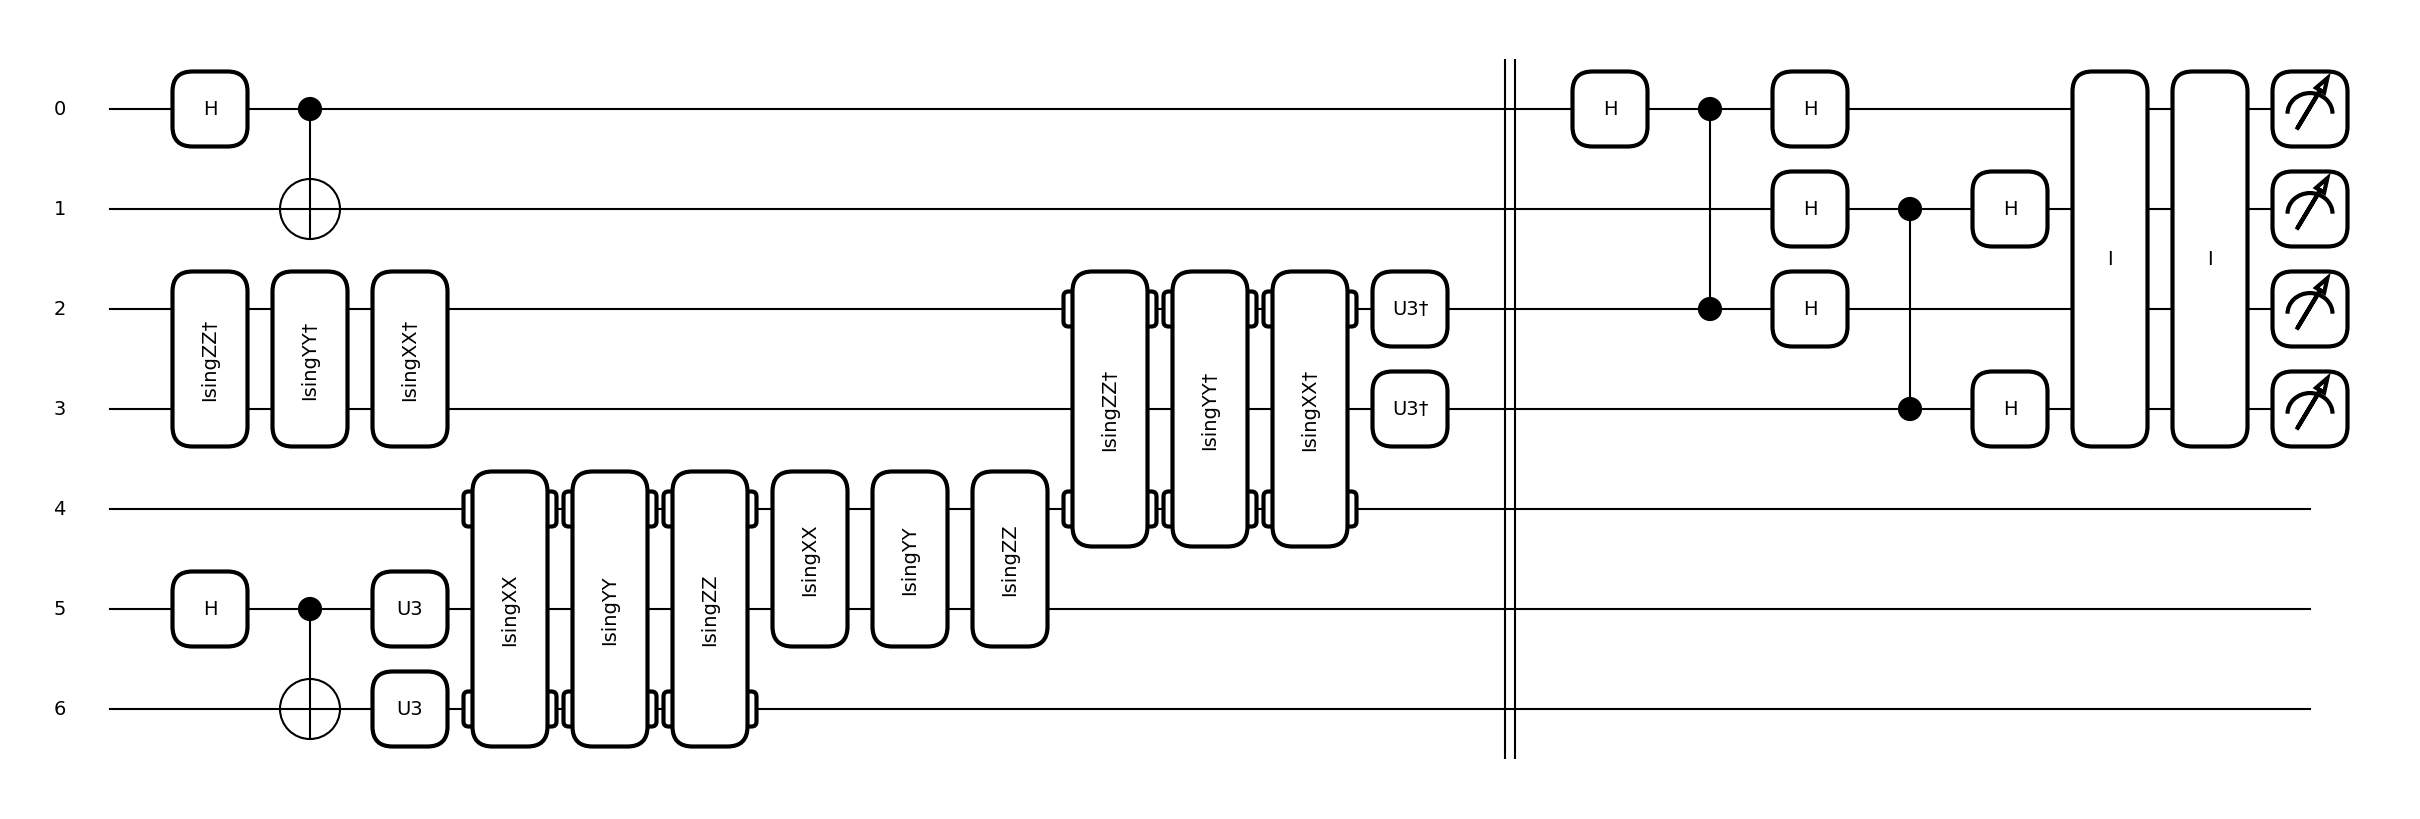

In [8]:
import matplotlib.pyplot as plt
qml.drawer.use_style("black_white")
params = np.array([0]*npar)
fig, ax = qml.draw_mpl(circuit)(params)
plt.show()

In [9]:
@qml.qnode(dev,interface='tf')
def circuit_train(params):
    state_preparation_validation(name='noisy_GHZ_bitflip_m', p=p , m=m , h=h)
    dqnn(m,params)
    return qml.density_matrix([m + i for i in range(m)])

@qml.qnode(dev,interface='tf')
def circuit_valid(params):
    state_preparation_validation(name='rigged_QDC', p=p, m=m, h=h)
    dqnn(m,params)
    return qml.density_matrix([m + i for i in range(m)])

@qml.qnode(dev,interface='tf')
def circuit_target():
    state_preparation_validation('GHZ_m_target',p=p, m=m, h=h)
    return qml.density_matrix(list(range(m)))

@qml.qnode(dev,interface='tf')
def circuit_Reny(params):
    state_preparation_validation(name='noisy_GHZ_bitflip_m', p=p , m=m , h=h)
    dqnn1(m,params)
    return qml.density_matrix(2*m+h-1)


In [10]:
def Fidelity(params):#Fid_discriminated
    p0 = circuit(params)
    #convert to fidelity
    Fidelity_output = 2*p0-1
    return Fidelity_output

In [11]:
def cost(params):
    cost =1-Fidelity(params)
    return cost

def cost_av(params,batch):
    np.random.seed(0)
    cost_avv = []
    for i in range(batch):
        cost_avv.append(cost(params)) 
    return sum(cost_avv)/batch

In [12]:
# Note that np.random.seed(0) leads to have a fixed data set in the number of batch during the training.
def fid_valid(params,batch):
    np.random.seed(0)
    fid = []
    for i in range(batch):
        a = circuit_target()
        b = circuit_valid(params)
        fidelity_evaluation = qml.math.fidelity(a,b)
        fid.append(fidelity_evaluation)
    return sum(fid)/batch
    
def fid_train(params,batch):
    np.random.seed(0)
    fid = []
    for i in range(batch):
        b = circuit_train(params)
        a = circuit_target()
        fidelity_train = qml.math.fidelity(a,b)
        fid.append(fidelity_train)
    return sum(fid)/batch  
    
def Reny_hiddenentropy(params):
    reny1 = np.trace(np.matmul(circuit_Reny(params),circuit_Reny(params)))
    reny = -np.log(reny1)
    return reny

def Reny_finalentropy(params):
    reny1 = np.trace(np.matmul(circuit_train(params),circuit_train(params)))
    reny = -np.log(reny1)
    return reny

In [13]:
np.random.seed(0)

#with batch

init_dqnn_weights = np.random.rand(npar)
dqnn_weights = tf.Variable(init_dqnn_weights,dtype=tf.float64)


loss_val_f = []
par = []


batch = 1
epochs = 50
p = 0.2

params = dqnn_weights
for step in range(epochs):
        opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.4)
        #opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
        
        loss = lambda: cost_av(params,batch)    
        
        opt.minimize(loss, [params])

        loss_val = loss().numpy()
        par.append(params.value())

        loss_val_f.append(loss_val)
        
        #par.append(p)
        
        print("Step {}: loss = {} ".format(step, loss_val))



Step 0: loss = 0.6248779296875 
Step 1: loss = 0.5855560302734375 
Step 2: loss = 0.566558837890625 
Step 3: loss = 0.553131103515625 
Step 4: loss = 0.54205322265625 
Step 5: loss = 0.5349578857421875 
Step 6: loss = 0.5248870849609375 
Step 7: loss = 0.5096588134765625 
Step 8: loss = 0.487274169921875 
Step 9: loss = 0.4529876708984375 
Step 10: loss = 0.3887481689453125 
Step 11: loss = 0.2980804443359375 
Step 12: loss = 0.215850830078125 
Step 13: loss = 0.16571044921875 
Step 14: loss = 0.12841796875 
Step 15: loss = 0.1030120849609375 
Step 16: loss = 0.081695556640625 
Step 17: loss = 0.0648193359375 
Step 18: loss = 0.0499725341796875 
Step 19: loss = 0.038299560546875 
Step 20: loss = 0.02984619140625 
Step 21: loss = 0.02362060546875 
Step 22: loss = 0.019317626953125 
Step 23: loss = 0.0165863037109375 
Step 24: loss = 0.0142364501953125 
Step 25: loss = 0.01226806640625 
Step 26: loss = 0.01055908203125 
Step 27: loss = 0.009674072265625 
Step 28: loss = 0.009262084960937

In [14]:
trainb = []
for i in range(epochs):
    fidelity_train = fid_train(par[i],batch)
    trainb.append(fidelity_train)
    
validb = []  
for i in range(epochs):
    fidelity_evaluation=fid_valid(par[i],batch)
    validb.append(fidelity_evaluation)

/Users/neda/anaconda3/lib/python3.11/site-packages/pennylane/_qubit_device.py:981: UserWarning: Requested state or density matrix with finite shots; the returned state information is analytic and is unaffected by sampling. To silence this warning, set shots=None on the device.
  warnings.warn(


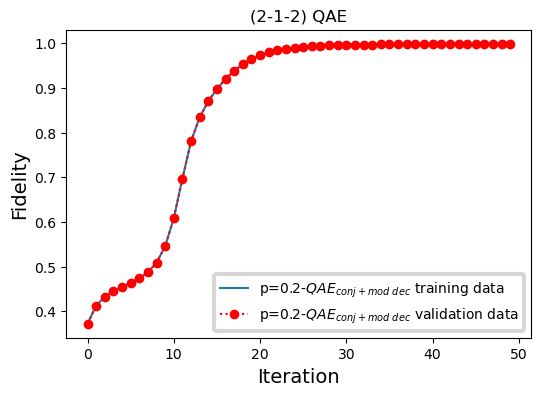

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(range(epochs), trainb, label="p=0.2-${QAE}_{conj+mod~dec}$ training data")
plt.plot(range(epochs), validb, label="p=0.2-${QAE}_{conj+mod~dec}$ validation data",color='red', marker='o', linestyle='dotted')
#plt.title("Fidelity for ({}-{}-{})  Modified decoder DQNN with a conjugate layer noise={}".format(m,h,m,p))
plt.title("({}-{}-{}) QAE".format(m,h,m))
plt.xlabel("Iteration",fontsize='14')
plt.ylabel("Fidelity",fontsize='14')
plt.legend()
plt.show()

In [16]:
renm = []
for i in range(epochs):
    hid = Reny_hiddenentropy(par[i])
    renm.append(hid)
    
renf = []  
for i in range(epochs):
    fin=Reny_finalentropy(par[i])
    renf.append(fin)

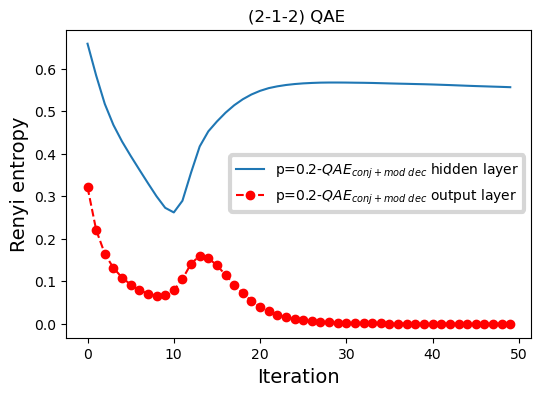

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(range(epochs), renm, label="p=0.2-${QAE}_{conj+mod~dec}$ hidden layer")
plt.plot(range(epochs), renf, label="p=0.2-${QAE}_{conj+mod~dec}$ output layer",color='red', marker='o', linestyle='dashed')
plt.title("({}-{}-{}) QAE ".format(m,h,m,p))
plt.xlabel("Iteration",fontsize='14')
plt.ylabel("Renyi entropy",fontsize='14')
plt.legend()
plt.show()